In [139]:
%reload_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

pd.options.display.max_colwidth = 100

import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot, offline
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

import requests

from os import listdir
import unicodedata

import json

from paths import *
from tools.vizu import remove_acentos
from tools.vizu import normalize_cols
from tools.io import read_sheets


from datetime import datetime
today = datetime.today().strftime('%Y-%m-%d')


# Import Data

# Brasil.IO

In [22]:
####### IMPORT DATA ######
url = 'https://brasil.io/api/dataset/covid19/caso/data?format=json'
df_final = pd.DataFrame()

while url != None:
    
    print(url)
    response = requests.get(url)
    data = response.text
    parsed = json.loads(data)
    url = parsed['next']
    df = pd.DataFrame(parsed['results']).sort_values(by='confirmed',ascending=False)
    df_final = pd.concat([df_final,df], axis=0)

https://brasil.io/api/dataset/covid19/caso/data?format=json
https://brasil.io/api/dataset/covid19/caso/data?format=json&page=2
https://brasil.io/api/dataset/covid19/caso/data?format=json&page=3
https://brasil.io/api/dataset/covid19/caso/data?format=json&page=4
https://brasil.io/api/dataset/covid19/caso/data?format=json&page=5
https://brasil.io/api/dataset/covid19/caso/data?format=json&page=6
https://brasil.io/api/dataset/covid19/caso/data?format=json&page=7
https://brasil.io/api/dataset/covid19/caso/data?format=json&page=8
https://brasil.io/api/dataset/covid19/caso/data?format=json&page=9
https://brasil.io/api/dataset/covid19/caso/data?format=json&page=10
https://brasil.io/api/dataset/covid19/caso/data?format=json&page=11
https://brasil.io/api/dataset/covid19/caso/data?format=json&page=12
https://brasil.io/api/dataset/covid19/caso/data?format=json&page=13
https://brasil.io/api/dataset/covid19/caso/data?format=json&page=14
https://brasil.io/api/dataset/covid19/caso/data?format=json&page

## transformation

In [140]:
from tools.manipulation import create_br_not_sp

df = df_final.sort_values(by='confirmed',ascending=False)
dd = create_br_not_sp(df)

### GET ONLY LAST DAY
mask = dd['date'] < today
dd = dd[mask]

dd = dd.sort_values(by=['date'],ascending=False)
dd = dd.sort_values(by=['confirmed'],ascending=False)

# get only the states
mask = ((dd['place_type']!='city'))
df_states = dd[mask]
df_states = df_states.sort_values(by=['date'],ascending=False)

In [141]:
#### CHOSE CITIES TO START SELECTED IN GRAPH

# in_cities = ['Brasil','Exceto SP' ,'SP', 'RJ']



In [144]:
from tools.vizu import brasil_vis

escala  = 'lin'
cities  = cities
largura = None
save    = True
in_cities = ['Brasil','SP', 'RJ']

# mask = ((dd[var_col]>0))
# dd = dd[mask]

## confirmed or deaths
for var in ['deaths','confirmed']:
    
    
    fig = brasil_vis(df_states, var_col,in_cities, drop_cities, escala, today='23-03-2020', save=True)

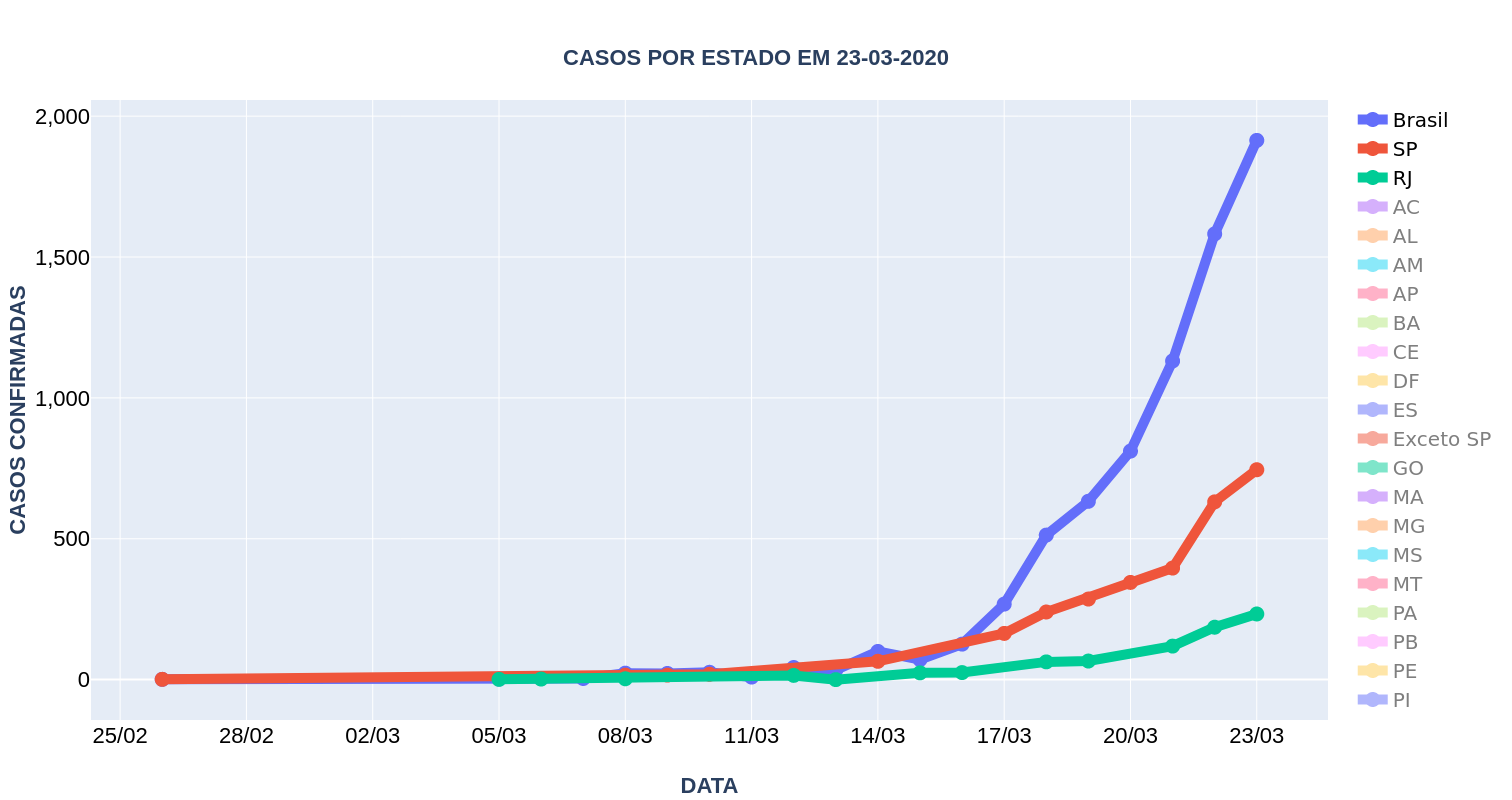

In [145]:
fig